In [1]:
from scmodels import SCM
import random, math

In [2]:
def get_distributions():
    ep = .1
    dists = [
        f"LogLogistic(alpha={random.randint(5, 20)}, beta={round(random.uniform(1,3.5),1)})",
        f"Normal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"LogNormal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"Benini(alpha={round(random.random() + ep, 1)}, beta={round(random.random() + ep, 1)}, sigma={round(random.random() + ep, 1)})",
        f"Beta(alpha={round(random.random() + ep, 1)}, beta={round(random.random() + ep, 1)})",
        f"Exponential(rate={round((random.random() + ep) * 10, 1)})",
        f"FDistribution(d1={random.randint(2, 4)}, d2={random.randint(5, 8)})",
        f"Gamma(k={round((random.random() + ep) * 4, 1)}, theta={round((random.random() + ep) * 8, 1)})",
        f"GammaInverse(a={round((random.random() + ep) * 4, 1)}, b={round((random.random() + ep) * 8, 1)})",
        f"Bernoulli({round(random.random(), 1)})",
        f"Binomial(n={random.randint(2, 10)}, p={round(random.random(), 1)}, succ={random.randint(3, 20)}, fail={random.randint(3, 20)})",
        f"BetaBinomial(n={random.randint(10, 100)}, alpha={round(random.random() + ep, 1)}, beta={round(random.uniform(2, 5),1)})",
        f"Die(sides={random.randint(4, 10)})",
        f"DiscreteUniform(items='1 2 3')",
        f"Geometric(p={round(random.random(), 2)})",
        f"Poisson(lamda={round(random.random() + ep, 1)})",
        f"FiniteRV({{{random.randint(5, 10)}: 1/2, {random.randint(0, 3)}: 1/6, {random.randint(15, 25)}: 1/6, {random.randint(30, 50)}: 1/6}})"
    ]
    
    return dists

In [3]:
def add_noise(dist):
    noise_ops = [False, True]
    op = random.choices(noise_ops, weights=(5, 1), k=1)[0]
    if op:
        dist = f"( {dist} ) * N"
    
    return dist

In [4]:
def add_complex_operation(dist):
    complex_ops = [False, "sqrt", "**2"]
    op = random.choices(complex_ops, weights=(10, 1, 1), k=1)[0]
    if op:
        if "*" in op:
            dist = f"( {dist} ){op}"
        else:
            dist = f"{op} ( {dist} )"
    
    return dist

In [5]:
def create_simple_operation(dist, parent):
    simple_ops = ["+", "*", "()"]
    op_1 = random.choices(simple_ops, weights=(4, 4, 1), k= 1)[0]
    if op_1 == "()":
        op_2 = random.choices(simple_ops, weights=(1, 1, 0), k= 1)[0]
        dist = f"{op_1[0]} {dist} {op_2} {parent} {op_1[1]}"
    else:
        dist = f"{dist} {op_1} {parent}"
    
    return dist

In [6]:
def get_child_distribution(parents):
    dist = f"{parents[0]}"
    count = 0
    for p in parents[1:]:
        dist = create_simple_operation(dist, p)
        count += 1
        
        if count > 2:
            dist = add_complex_operation(dist)
            count = 0
        
        dist = add_noise(dist)
    
    dist = f"{dist} * N"
    return dist

In [7]:
def get_parent_levels(levels_and_distributions):
    levels = list(range(len(levels_and_distributions)))
    level_probs = [round(math.exp(1.5 * l), 1) for l in levels]
    parent_levels = []
    for l in levels:
        possible_level = random.choices(levels, level_probs, k=1)[0]
        if possible_level not in parent_levels:
            parent_levels.append(possible_level)
    
    return parent_levels

In [8]:
def get_parents(levels_and_distributions):
    parents = []
    parent_levels = get_parent_levels(levels_and_distributions)
    for level in parent_levels:
        possible_parents = levels_and_distributions[level][1]
        num_parents = random.randint(1, len(possible_parents))
        parents.extend(random.sample(possible_parents, num_parents))
    
    return parents

In [9]:
def populate_level_distributions(level, level_data, levels_and_distributions):
    level_dists = []
    dist_names = []
    for n in range(level_data['num']):
        name = level_data['name']+str(n+1)
        
        if level == 0:
            dist = "N"
        else:
            dist = get_child_distribution(get_parents(levels_and_distributions))
            
        dist = f"{name} = {dist}, N ~ {random.sample(get_distributions(), 1)[0]}"
        level_dists.append(dist)
        dist_names.append(name)
    
    levels_and_distributions[level] = (level_dists, dist_names)

In [10]:
def create_scm(level_name_numnodes):
    levels_and_distributions = {}
    for level, level_data in level_name_numnodes.items():
        populate_level_distributions(level, level_data, levels_and_distributions)

    scm_dists = []
    for n in range(len(levels_and_distributions)):
        scm_dists.extend(levels_and_distributions[n][0])
    
    scm = SCM(
        scm_dists
    )
    
    return scm

In [11]:
def create_names_and_num_nodes_dict(nodes_per_level, level_names):
    level_name_numnodes = {}
    for n, name in enumerate(level_names):
        level_name_numnodes[n] = {'name': name, 'num': nodes_per_level[n]}
        
    return level_name_numnodes

In [12]:
def get_level_names(numnodes_per_level):
    level_names = []
    for n in range(len(numnodes_per_level)):
        level_names.append(chr(65 + n))
    
    return level_names

In [13]:
def create_scm_from_nodes_list(nodes_list):
    level_names = get_level_names(nodes_list)
    level_name_numnodes = create_names_and_num_nodes_dict(nodes_list, level_names)
    
    scm = create_scm(level_name_numnodes)
    return scm

In [14]:
def get_numnodes_per_level(input_nodes):
    nodes = input_nodes
    levels = int(math.pow(nodes, 1/3))
    numnodes_per_level = []
    for n in range(levels):
        ub = round(math.log(nodes)) - 0.6
        lb = ub - 0.7
        level_nodes = int(math.exp(round(random.uniform(lb,ub), 1)))
        if level_nodes == 0 : break

        numnodes_per_level.append(level_nodes)
        nodes -= level_nodes
        
    return numnodes_per_level

In [15]:
def create_scm_from_num_nodes(input_nodes):
    nodes_list = get_numnodes_per_level(input_nodes)
    scm = create_scm_from_nodes_list(nodes_list)
    return scm

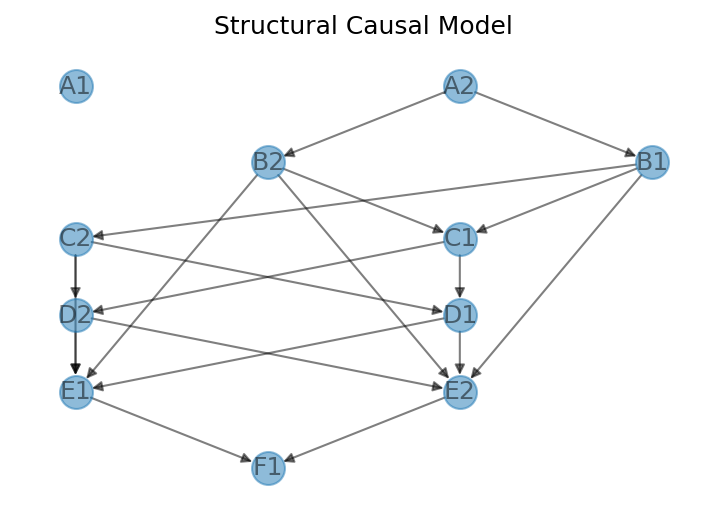

In [16]:
input_nodes = [2,2,2,2,2,1]
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [17]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,B1,B2,C2,C1,D1,D2,E1,E2,F1
0,14.692564,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00
1,-16.872698,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00
2,-9.754110,1.0,3.536206,2.257752,152.056845,23.175831,38475.652227,137.509501,1.488595e+06,1.410378e+06,2.898973e+06
3,-15.294286,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
4,19.365724,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
95,18.950426,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00
96,-46.808139,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00
97,28.281767,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
98,-23.110918,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00


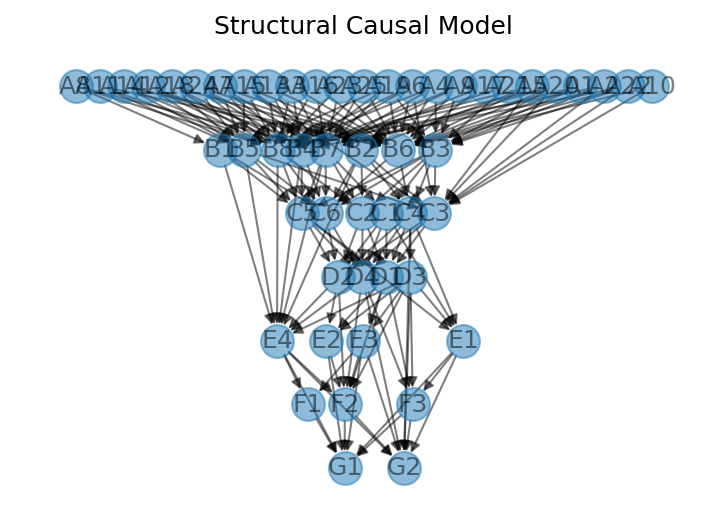

In [18]:
input_nodes = [25, 8, 6, 4, 4, 3, 2]
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [19]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float
<lambdifygenerated-56>:2: RuntimeWarning: invalid value encountered in sqrt
  return A16*A18*A25*sqrt(A4 + (A14*A24 + (A10*A22 + A2 + A23*A5*(A11 + A13 + A19*sqrt(A1*A3 + A15*A17*A20 + A6 + A9) + A7))*N)*N)*N
<lambdifygenerated-57>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(A13 + A17 + (A1*A15 + A12 + A20 + A24 + A25*A8 + A7 + A9 + (A16*A19*(A23 + A3)*N + A4)*N)*N)*N
<lambdifygene

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D4,E1,E3,E2,E4,F3,F1,F2,G1,G2
0,1.293834,0.0,0.612236,1.681724,1.954713,2.0,1.0,58.0,2.0,10.701714,...,2.097528e+38,0.000000,0.000000e+00,0.000000e+00,8.638638e+42,8.390112e+38,8.638638e+42,0.0,8.638638e+42,0.0
1,2.639689,1.0,6.970508,1.051316,0.334467,3.0,0.0,56.0,2.0,11129.097340,...,2.793590e+05,0.000000,1.136075e+07,1.136075e+07,7.218130e+08,1.676154e+06,7.331738e+08,0.0,7.842994e+08,0.0
2,4.976261,0.0,0.154383,0.007444,0.178725,2.0,0.0,60.0,0.0,13.983726,...,1.605700e+07,0.000000,0.000000e+00,0.000000e+00,1.771857e+11,3.211400e+07,1.771857e+11,0.0,1.771857e+11,0.0
3,8.372622,0.0,6.788618,1.453704,0.062554,3.0,0.0,60.0,1.0,1.319743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,74.388118,0.0,0.227275,0.871678,10.117525,3.0,0.0,52.0,1.0,9.562071,...,NaN,-0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,36.410402,0.0,15.509111,0.511573,6.284147,1.0,0.0,54.0,0.0,3.635785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,10.403438,0.0,-0.236709,0.992361,9.609362,2.0,1.0,56.0,2.0,43227.774557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,5.201021,0.0,2.055387,0.133732,6.066820,1.0,0.0,60.0,1.0,2.612257,...,1.112622e+21,78703.584284,-4.794853e+06,2.481570e+19,1.194174e+27,7.788356e+21,1.194174e+27,0.0,-5.148209e+114,0.0
98,65.377992,1.0,4.577943,2.166495,0.016678,3.0,0.0,58.0,1.0,585.982255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


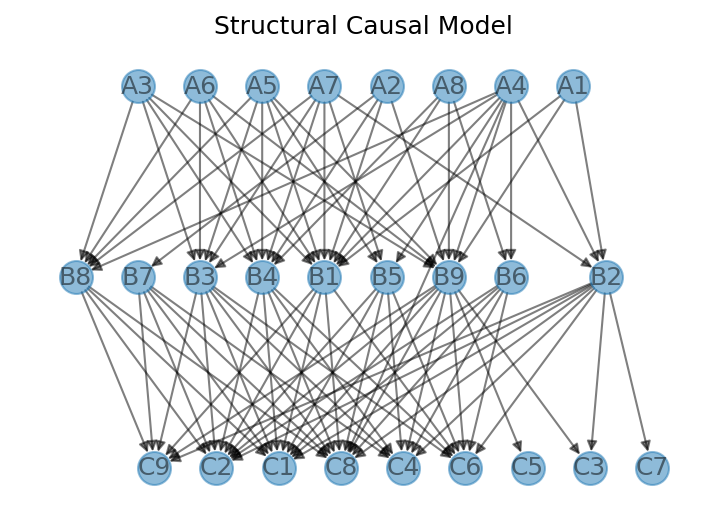

In [20]:
input_nodes = 30
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [21]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,A3,A4,A5,A6,A7,A8,B7,B2,...,B9,C7,C1,C2,C3,C4,C5,C6,C8,C9
0,1.212949e+04,3.710421,1.0,6.230151e+06,69.0,1.0,6.400677,1.0,11.131263,1.744480e+07,...,5.607887e+11,1.389579e+08,9.596558e+32,1.798179e+21,1.682418e+13,1.327816e+20,4.205915e+13,2.121224e+12,1.385784e+28,1.282358e+25
1,8.720507e-02,2.507648,1.0,3.168890e+04,84.0,0.0,-2.507924,2.0,7.522943,1.812454e+05,...,1.389617e+04,2.969640e+05,-1.308499e+19,5.944947e+13,6.439672e+06,7.844115e+09,9.032511e+05,5.027494e+07,9.087926e+17,1.242413e+15
2,9.811597e+12,1.050047,1.0,1.911909e+06,79.0,0.0,6.260256,1.0,1.050047,9.811600e+12,...,0.000000e+00,9.772312e+13,0.000000e+00,4.997242e+20,3.139712e+14,0.000000e+00,0.000000e+00,3.128143e+09,6.455542e+22,7.761380e+18
3,6.408186e+02,8.469781,1.0,5.997869e+02,74.0,1.0,-0.299838,2.0,8.469781,1.443994e+03,...,0.000000e+00,5.847674e+03,0.000000e+00,-7.626461e+10,4.620782e+04,0.000000e+00,0.000000e+00,-3.012242e+05,2.199926e+11,1.033535e+11
4,1.345030e-01,0.806630,1.0,3.738909e+01,69.0,1.0,3.533888,1.0,0.806630,2.930878e+02,...,1.254259e+01,2.030985e+03,0.000000e+00,6.087260e+09,9.474542e+03,4.466118e+04,8.779810e+02,4.370080e+03,8.299818e+07,1.579924e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.211231e+14,0.467430,1.0,1.431552e+04,84.0,2.0,3.901329,1.0,1.402289,1.211231e+14,...,0.000000e+00,1.662904e+15,0.000000e+00,2.218337e+25,3.997062e+15,0.000000e+00,0.000000e+00,4.079065e+18,2.917781e+29,2.731137e+37
96,1.339261e+07,0.639879,1.0,2.626622e+03,74.0,1.0,5.341663,1.0,0.639879,1.339642e+07,...,2.314340e+10,3.549848e+06,-0.000000e+00,1.843070e+17,7.178606e+11,1.379337e+15,1.388604e+12,3.209025e+11,-1.522529e+20,6.535961e+22
97,2.224543e+15,1.382251,1.0,6.773507e+02,89.0,0.0,3.484533,2.0,2.764502,2.224543e+15,...,9.425736e+18,5.860910e+16,-0.000000e+00,2.145640e+22,3.016947e+20,-8.760332e+26,6.126728e+20,-1.345982e+44,4.834982e+24,8.884450e+37
98,3.486735e+11,1.298827,0.0,1.577021e+06,79.0,0.0,6.844635,2.0,3.896482,3.486801e+11,...,0.000000e+00,6.019408e+12,-0.000000e+00,6.165025e+20,1.080908e+13,0.000000e+00,0.000000e+00,4.864345e+09,-9.611148e+22,8.586293e+18
